<a href="https://colab.research.google.com/github/EOL/computer-vision-with-EOL-images/blob/master/play_for_beginners/plant_poll_generate_tags_bioclipv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Using BIOCLIP v2 to add plant-pollinator co-occurrence tags for ladybugs, beetles, and insects in plant images
---
*Last Updated 18 Fev 2026*  
-Runs in Python 3 with BIOCLIPv2-   

Using BIOCLIPv2, [a vision foundation model](https://arxiv.org/abs/2311.18803) implemented with [pybioclip](https://github.com/Imageomics/pybioclip/tree/main) and trained on [Tree of Life 10M images](https://huggingface.co/datasets/imageomics/TreeOfLife-10M) as a method to do customized, large-scale image processing. EOL Angiosperm images will be tagged if insect visitors are present using object detection. Tags will further extend EOLv3 image search functions.

Notes:   
* Run code blocks by pressing play button in brackets on left
* Change parameters using form fields on right (find details at corresponding lines of code by searching '#@param')

References:   
* Code modified from the [Imageomics pybioclip tutorial](https://imageomics.github.io/pybioclip/python-tutorial/)
* Check out [Imageomics pybioclip repo](https://github.com/Imageomics/pybioclip/tree/main) for more documetation and tutorials

## Installs & Imports
---

In [ ]:
#@title Choose where to save results
import os

# Use dropdown menu on right
save = "in Colab runtime (files deleted after each session)" #@param ["in my Google Drive", "in Colab runtime (files deleted after each session)"]

# Mount google drive to export image tagging file(s)
if 'Google Drive' in save:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

# Download helper_funcs folder
!pip3 -q install --upgrade gdown
!gdown 1TtL_NvD4oOXJaiqKfQs_qULuNAZDsF2J
!tar -xzvf helper_funcs.tar.gz -C .

# Install requirements.txt
!pip3 -q install -r requirements.txt
print('\n\n\n \033[91m If ERROR from pip dependency solver listed above, please check through conflicting version dependencies and/or open an issue on the CV for EOL images Github: https://github.com/aubricot/computer_vision_with_eol_images/issues. \033[0m')

# Set up directory structure
basewd = "/content/drive/MyDrive/train"
cwd = basewd + '/' + 'bioclip2'
if not os.path.exists(cwd):
    os.makedirs(cwd)
    os.chdir(cwd)
    os.makedirs('data/imgs')
    os.makedirs('data/img_info')
    os.makedirs('data/results')

In [ ]:
#@title Import libraries

# Install pybioclip
!pip install pybioclip

# For importing/exporting files, working with arrays, etc
import glob
import pathlib
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile
import numpy as np
import csv
import time
import pandas as pd
from bioclip import TreeOfLifeClassifier, Rank
from PIL import Image
import requests
import urllib3
from io import StringIO
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# For downloading images
!apt-get -qq install aria2

# For drawing onto and plotting images
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sys.path.append('/content')

# Define EOL CV custom functions
from wrangle_data import *

def read_datafile(url, sep="\t"):
    response = requests.get(url, verify=False, timeout=20)
    response.raise_for_status()
    return pd.read_csv(StringIO(response.text), sep=sep)

## Generate tags for images
---
Run EOL 20k image bundles through pre-trained object detection models and save results in 4 batches (A-D) of 5000 images each.

/content
/content/drive/MyDrive/train/bioclip2/data/imgs
Downloading...
From: https://drive.google.com/uc?id=1WVafbU3htUUiSo-Qvs3sA1Y0Medz4o7D
To: /content/drive/MyDrive/train/bioclip2/data/imgs/542.6248219776.jpg
100% 2.66M/2.66M [00:00<00:00, 264MB/s]
/content/drive/MyDrive/train/bioclip2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

embeddings/txt_emb_species.npy:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

embeddings/txt_emb_species.json:   0%|          | 0.00/91.6M [00:00<?, ?B/s]

100%|██████████| 1/1 [00:03<00:00,  3.28s/images]


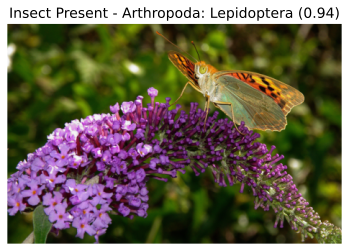

In [3]:
#@title Test: Run with sample EOL Angiosperm image (To test with your own image, upload file to data/imgs and update fn formfield)

# Run with sample EOL image
# Define image filepath and name
fn = "542.6248219776.jpg" #@param ["542.6248219776.jpg"] {allow-input: true}
img_fpath = 'data/imgs/' + fn

# Download image
%cd $cwd
%cd data/imgs
!gdown 1WVafbU3htUUiSo-Qvs3sA1Y0Medz4o7D
%cd $cwd

# Load in Tree of Life Classifier
classifier = TreeOfLifeClassifier()

# Run inference on image
predictions = classifier.predict(img_fpath, Rank.SPECIES)

# Filter predictions that contain "Arthropoda"
filter = "Arthropoda"
filtered_pred = [p for p in predictions if p.get('phylum')==filter]

# Build figure title based on filtered predictions
if filtered_pred:
    top = filtered_pred[0]
    label = "Insect Present - " + top["phylum"] + ": " + top["order"]
    score = top['score']
    title = f"{label} ({score:.2f})"
else:
    title = f"No {filter} prediction found"

# Show image with predictions
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(img_fpath))
plt.axis('off')
plt.title(title, fontsize=14)
plt.show()

### Generate tags: Run inference on EOL images & save results for tagging - Run 4X for batches A-D
Use 20K EOL Angiosperm image bundle to identify possible pollinators that are present. Results are saved to [tags_file].tsv. Run this section 4 times (to make batches A-D) of 5K images each to incrementally save in case of Colab timeouts.

In [5]:
#@title Enter EOL image bundle and choose inference settings. Change **tags_file** for each batch A-D
%cd $cwd

# Load in EOL Angiosperm 20k image bundle
bundle = "https://editors.eol.org/other_files/bundle_images/files/images_for_Angiosperms_20K_breakdown_download_000030.txt" #@param ["https://editors.eol.org/other_files/bundle_images/files/images_for_Angiosperms_20K_breakdown_download_000030.txt"] {allow-input: true}
df = read_datafile(bundle)
print("EOL image bundle with {} images: \n{}".format(len(df), df.head()))

# Test pipeline with a smaller subset than 5k images?
run = "test with tiny subset" # @param ["test with tiny subset"]

# Display detection results on images?
display_results = "yes (use this option if testing tiny subsets; only works for \u003C50 images)" # @param ["yes (use this option if testing tiny subsets; only works for <50 images)"]

# Take 5k subset of bundle for running inference
# Change filename for each batch
tags_file = "plant_poll_coocc_tags_c" #@param ["plant_poll_coocc_tags_a", "plant_poll_coocc_tags_b", "plant_poll_coocc_tags_c", "plant_poll_coocc_tags_d"] {allow-input: true}
tags_file = tags_file + ".txt"
imgs_dir = "data/imgs/"
outfpath = imgs_dir + tags_file
print("\nSaving tagging results to: \n{}".format(outfpath))

# Add 5k subset of image bundle urls as column in tags file
start, stop, cutoff = set_start_stop(run, df)
df = df.iloc[start:stop]
df.to_csv(outfpath, sep='\n', index=False, header=False)

/content/drive/MyDrive/train/bioclip2
EOL image bundle with 19999 images: 
   https://content.eol.org/data/media/5e/d9/15/509.32946649.jpg
0  https://content.eol.org/data/media/5e/d9/16/509.32946653.jpg
1  https://content.eol.org/data/media/5e/d9/17/509.32946654.jpg
2  https://content.eol.org/data/media/5e/d9/18/509.32946657.jpg
3  https://content.eol.org/data/media/5e/d9/19/509.32946659.jpg
4  https://content.eol.org/data/media/5e/e4/6e/509.33211309.jpg

Saving tagging results to: 
data/imgs/plant_poll_coocc_tags_c.txt


In [6]:
#@title Run inference for batches A-D
# Note: YOLO cannot parse images from URL, so images are temporarily downloaded
# Note: Takes 7-10 min per 5k imgs, aria2 downloads 16imgs at a time
%cd $imgs_dir
!aria2c -x 16 -s 1 --check-certificate=false --auto-file-renaming=false --retry-wait=10 --max-tries=5 -i $tags_file

# Verify that downloaded images are valid files
valid_image_count = 0
invalid_image_count = 0
for entry in os.scandir('.'):
    if entry.is_file() and not entry.name.endswith('.txt'):
        try:
            with Image.open(entry.path) as img:
                img.verify()  # Checks for integrity of image
            valid_image_count += 1
        except Exception as e:
            print(f"Invalid image file deleted: {entry.name}")
            os.remove(entry.path)
            invalid_image_count += 1
print(f"\nImage validation complete. {valid_image_count} valid images, {invalid_image_count} invalid images removed.")


# Check how many images downloaded
print("Number of files downloaded to Google Drive: ")
print(valid_image_count)
if (valid_image_count < cutoff) and ("tiny subset" not in run):
    print("\n\n\n \033[93m WARNING: Less than {} files were downloaded. This is likely due to broken EOL image bundle URLs.")

# Move tags file used for downloading images to data/img_info/
%cd $cwd
!mv data/imgs/*.txt data/img_info/

# Make a new list of successfully downloaded image files for running inference
inf_imgs = imgs_dir + tags_file
with open(inf_imgs, 'w', encoding='utf-8') as f:
    # Walk through data/imgs/ to list files
    for dir, dirs, files in os.walk(imgs_dir):
        files = [fn for fn in files]
        for fn in files:
            if 'txt' not in fn:
                out = "data/imgs/" + fn
                f.writelines(out + '\n')

# Inspect textfile of images for inference
df = pd.read_table(inf_imgs, header=None, sep='\r')
print("\nNumber of valid images ready for inference in {}: {}".format(inf_imgs, len(df)))

# Load in Tree of Life Classifier
classifier = TreeOfLifeClassifier()

# Run inference on image
img_fpaths = df[0].to_list()
predictions = classifier.predict(img_fpaths, Rank.SPECIES)
pred_df = pd.DataFrame(predictions)

/content/drive/MyDrive/train/bioclip2/data/imgs

02/18 17:11:59 [NOTICE] Downloading 5 item(s)

02/18 17:12:01 [NOTICE] Download complete: /content/drive/MyDrive/train/bioclip2/data/imgs/509.248559.jpg

02/18 17:12:01 [NOTICE] Download complete: /content/drive/MyDrive/train/bioclip2/data/imgs/509.248560.jpg

02/18 17:12:02 [NOTICE] Download complete: /content/drive/MyDrive/train/bioclip2/data/imgs/509.24356273.jpg

02/18 17:12:06 [NOTICE] Download complete: /content/drive/MyDrive/train/bioclip2/data/imgs/509.24356272.jpg

02/18 17:12:07 [NOTICE] Download complete: /content/drive/MyDrive/train/bioclip2/data/imgs/509.24356271.jpg

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
2ce326|OK  |   703KiB/s|/content/drive/MyDrive/train/bioclip2/data/imgs/509.248559.jpg
68e211|OK  |   695KiB/s|/content/drive/MyDrive/train/bioclip2/data/imgs/509.248560.jpg
cc74f3|OK  |   1.2MiB/s|/content/drive/MyDrive/train/biocl

100%|██████████| 6/6 [00:17<00:00,  2.91s/images]


In [ ]:
# Filter predictions that contain "Arthropoda"
filter = "Arthropoda" # @param ["Arthropoda"] {"allow-input":true}

# Group predictions by image (assuming one-to-many: multiple predictions per image)
grouped = pred_df.groupby('file_name')

for img_fpath, group in grouped:
    # Filter Arthropoda predictions for this image
    filtered_pred = group[group['phylum'] == filter].sort_values(by='score', ascending=False)

    # Build title based on grouped, filtered predictions
    if not filtered_pred.empty:
        top = filtered_pred.iloc[0]
        label = f"Insect Present - {top['phylum']}: {top['order']}"
        score = top['score']
        title = f"{label} ({score:.2f})"
    else:
        title = f"No {filter} prediction found"

    # Display image with title
    try:
        img = Image.open(img_fpath)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=14)
        plt.show()
    except Exception as e:
        print(f"Could not open image {img_fpath}: {e}")

print("\n\n~~~\n \033[92m Inference complete! \033[0m \n~~~")